# Comparison of logs from torchtune and PEFT

## imports

In [1]:
import re

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## load data

### load torchtune logs

In [3]:
with open("log_torchtune.txt", "r") as f:
    logs_tt = f.readlines()

In [4]:
pattern = re.compile(
    r"Step (\d+) \| loss:(\d+\.\d+) lr:(\d+\.\d+(?:e-\d+)?) tokens_per_second_per_gpu:(\d+\.\d+) "
    r"peak_memory_active:(\d+\.\d+) peak_memory_alloc:(\d+\.\d+) peak_memory_reserved:(\d+\.\d+)")
rows = []
for log in logs_tt:
    row = pattern.match(log.strip()).groups()
    step, loss, lr, dur, peak_memory_active, peak_memory_alloc, peak_memory_reserved = row
    rows.append((int(step), float(loss), float(lr), float(dur), float(peak_memory_active), float(peak_memory_alloc), float(peak_memory_reserved)))

In [5]:
df_tt = pd.DataFrame(
    rows,
    columns=["step", "loss", "lr", "tokens_per_second", "peak_memory_active", "peak_memory_alloc", "peak_memory_reserved"],
)

In [6]:
df_tt.shape

(652, 7)

### load peft logs

In [7]:
with open("log_peft_bnb-0.43.3.txt", "r") as f:
    logs_peft = f.readlines()

In [8]:
rows = []
for log in logs_peft:
    row = pattern.match(log.strip()).groups()
    step, loss, lr, dur, peak_memory_active, peak_memory_alloc, peak_memory_reserved = row
    rows.append((int(step), float(loss), float(lr), float(dur), float(peak_memory_active), float(peak_memory_alloc), float(peak_memory_reserved)))

In [9]:
df_peft = pd.DataFrame(
    rows,
    columns=["step", "loss", "lr", "tokens_per_second", "peak_memory_active", "peak_memory_alloc", "peak_memory_reserved"]
)

In [10]:
df_peft.shape

(704, 7)

### join

In [11]:
df = df_tt.merge(df_peft, on="step", suffixes=("_tt", "_peft"), how="outer")

## comparison

### loss

<Axes: title={'center': 'loss after 100 steps'}>

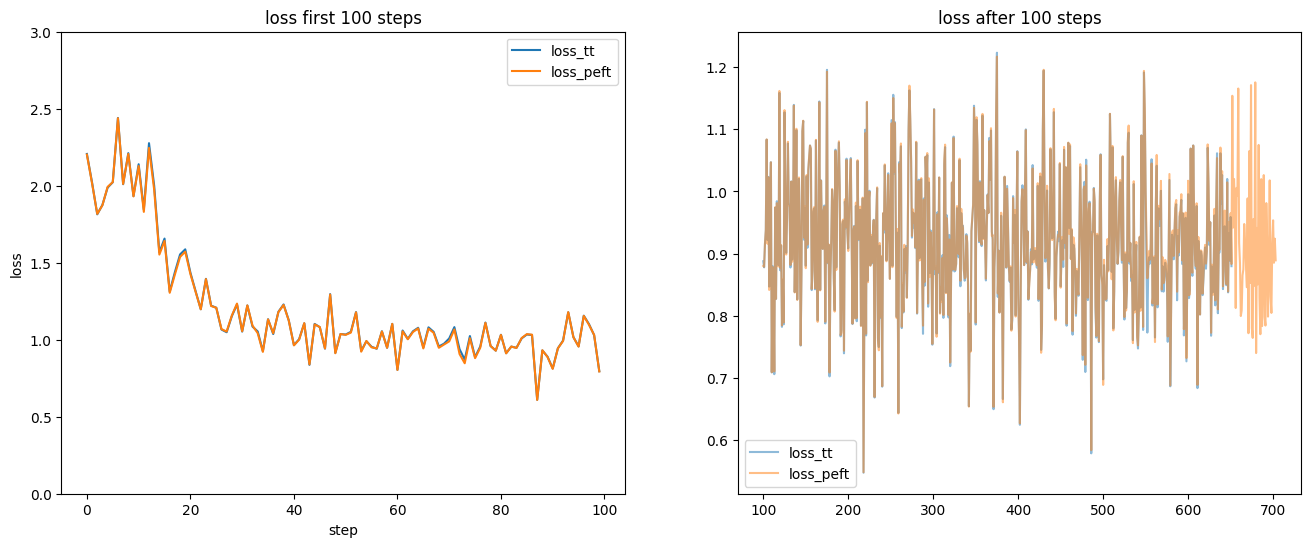

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kw = {"ylim": [0, 3], "ylabel": "loss", "xlabel": "step"}
df[["loss_tt", "loss_peft"]].head(100).plot(ax=axes[0], title="loss first 100 steps", **kw)
df[["loss_tt", "loss_peft"]].iloc[100:].plot(alpha=0.5, ax=axes[1], title="loss after 100 steps")

### loss (rolling mean)

<Axes: title={'center': 'loss after 100 steps, rolling mean (50)'}, xlabel='step', ylabel='loss'>

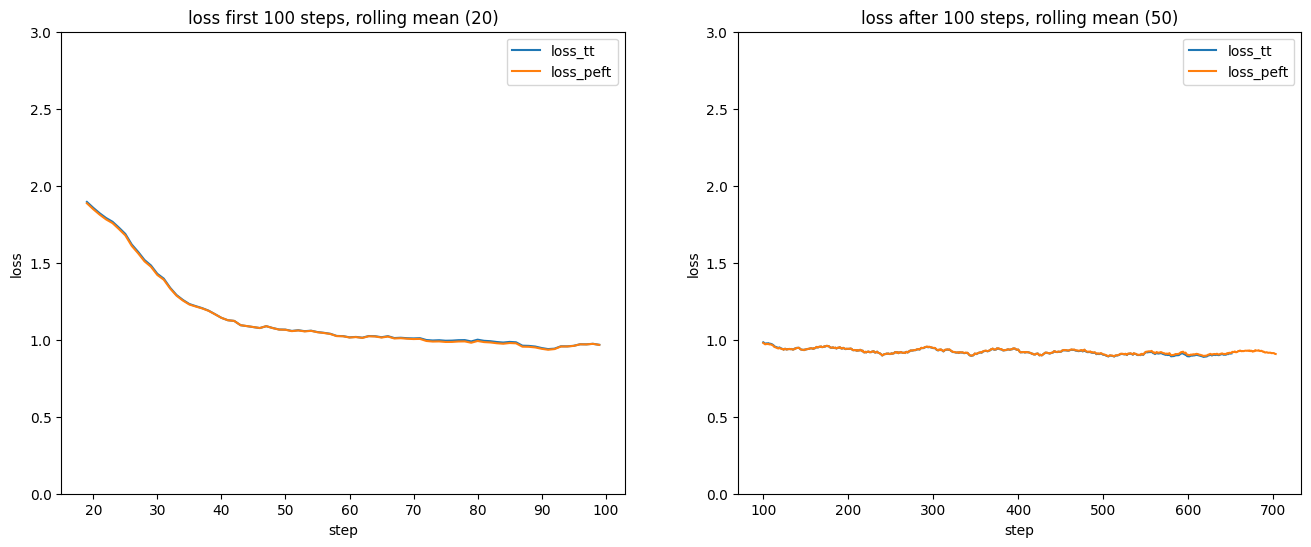

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kw = {"ylim": [0, 3], "ylabel": "loss", "xlabel": "step"}
df[["loss_tt", "loss_peft"]].rolling(20).mean().head(100).plot(ax=axes[0], title="loss first 100 steps, rolling mean (20)", **kw)
df[["loss_tt", "loss_peft"]].rolling(50).mean().iloc[100:].plot(ax=axes[1], title="loss after 100 steps, rolling mean (50)", **kw)

### tokens per second

<Axes: title={'center': 'tokens per second'}, xlabel='step', ylabel='tokens per second'>

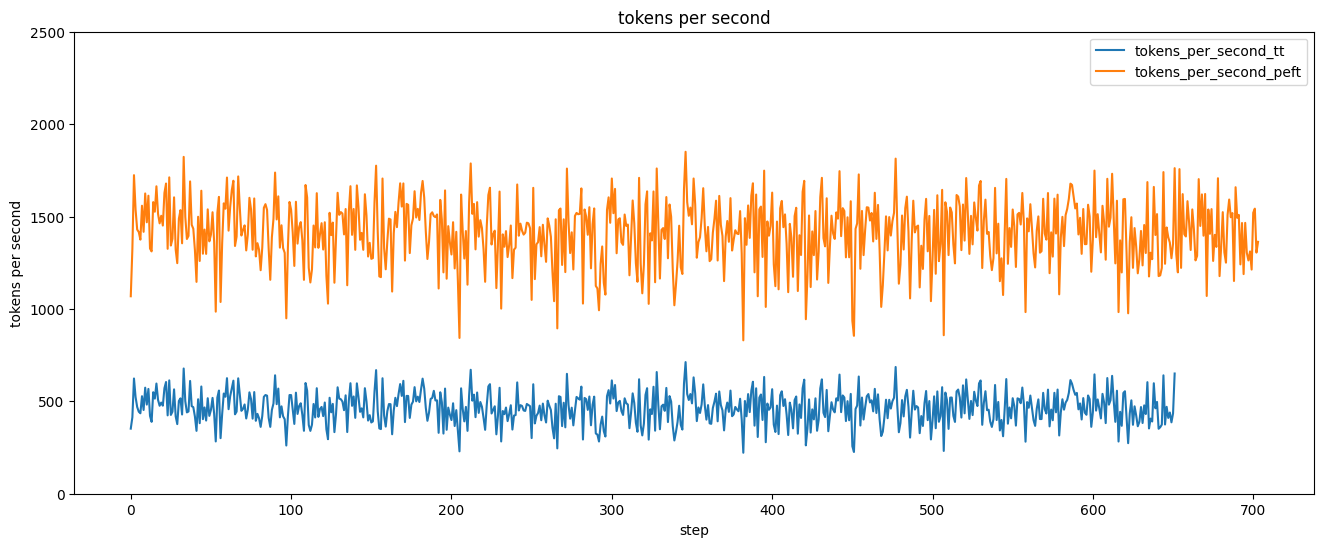

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))
kw = {"ylabel": "tokens per second", "xlabel": "step", "ylim": [0, 2500]}
df[["tokens_per_second_tt", "tokens_per_second_peft"]].plot(ax=ax, title="tokens per second", **kw)

Not sure where the difference comes from. I thought it might be because checkpointing was enabled when training the torchtune model, but even when disabling it, the times are pretty much the same.

### tokens per second (rolling mean)

<Axes: title={'center': 'tokens per second, rolling mean (50)'}, xlabel='step', ylabel='tokens per second'>

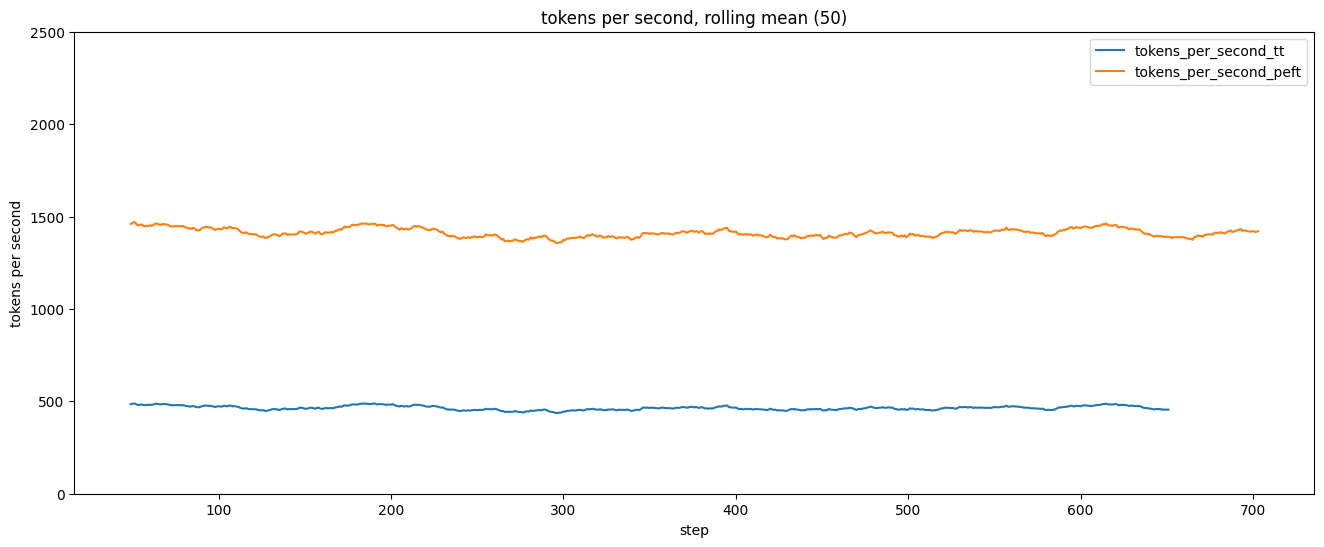

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))
kw = {"ylabel": "tokens per second", "xlabel": "step", "ylim": [0, 2500]}
df[["tokens_per_second_tt", "tokens_per_second_peft"]].rolling(50).mean().plot(ax=ax, title="tokens per second, rolling mean (50)", **kw)

### memory

<Axes: title={'center': 'memory'}, xlabel='step', ylabel='memory (GB)'>

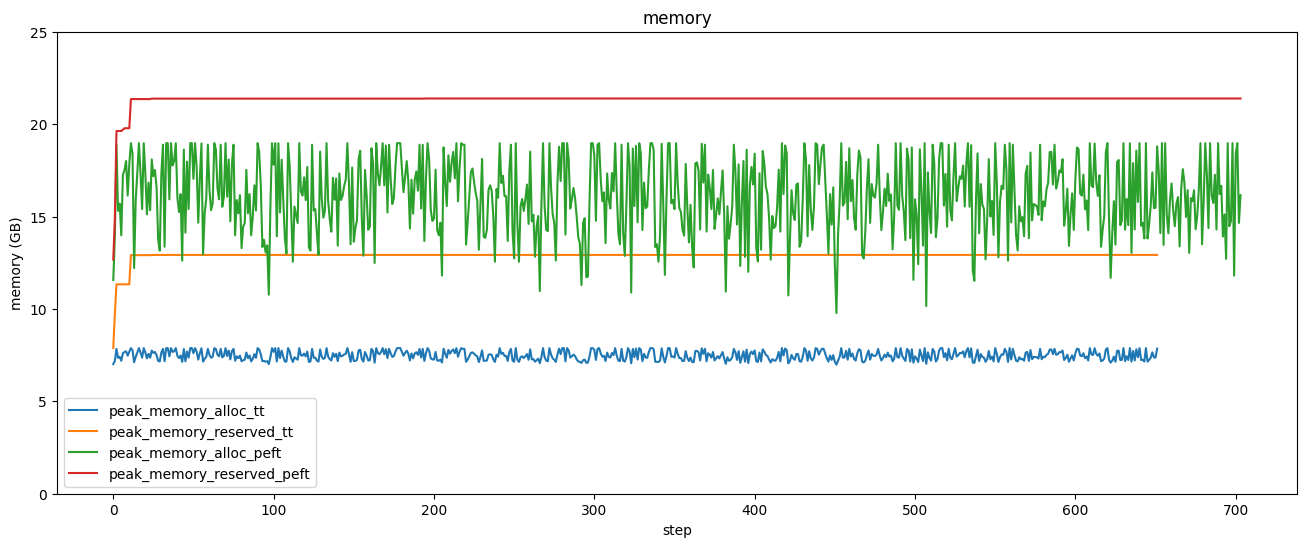

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
kw = {"ylabel": "memory (GB)", "xlabel": "step", "ylim": [0, 25]}
df[["peak_memory_alloc_tt", "peak_memory_reserved_tt", "peak_memory_alloc_peft", "peak_memory_reserved_peft"]].plot(ax=ax, title="memory", **kw)

### memory (rolling mean)

<Axes: title={'center': 'memory, rolling mean (50)'}, xlabel='step', ylabel='memory (GB)'>

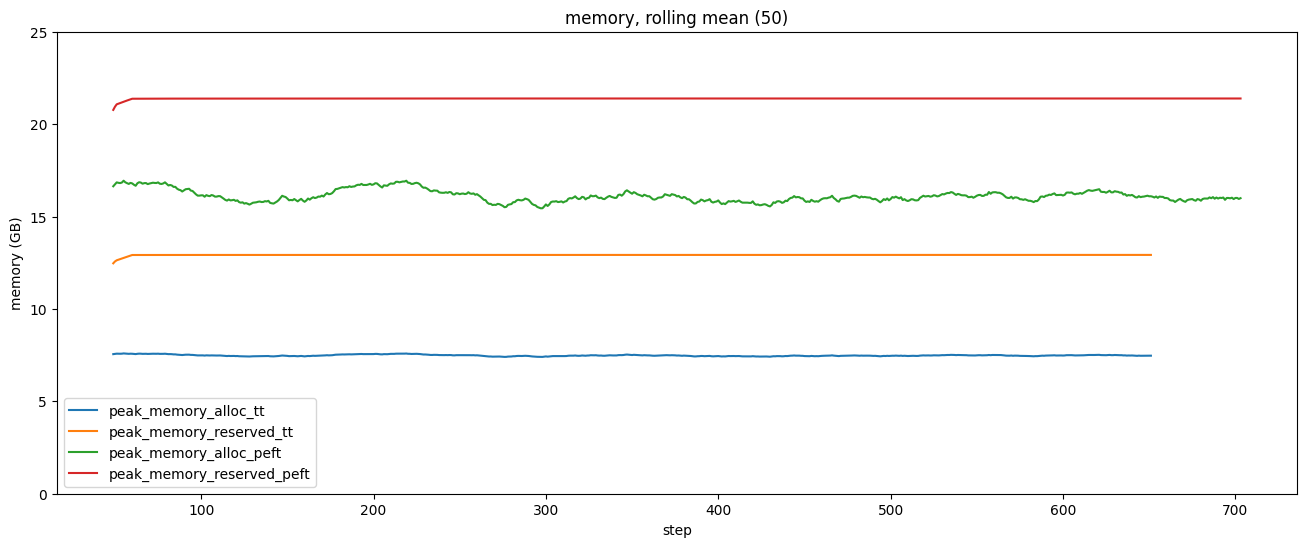

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))
kw = {"ylabel": "memory (GB)", "xlabel": "step", "ylim": [0, 25]}
df[["peak_memory_alloc_tt", "peak_memory_reserved_tt", "peak_memory_alloc_peft", "peak_memory_reserved_peft"]].rolling(50).mean().plot(ax=ax, title="memory, rolling mean (50)", **kw)